# Data Quality Audit — Philadelphia Crime Incidents

**Objective:** Conduct a reproducible, transparent assessment of data quality for the Philadelphia crime incidents dataset, focusing on completeness, accuracy, consistency, and validity.

**Scope:** Loading and versioning, spatial and temporal validation, missingness and bias analysis, duplicate detection, outlier detection, temporal coverage, and an overall quality score with recommendations.

**Approach:** Systematic tests and visualizations with conservative statistical thresholds (99% confidence), and a weighted quality score (completeness 40%, accuracy 30%, consistency 15%, validity 15%).

**Notebook Structure**
1. Data Loading & Version Tracking
2. Data Preprocessing (coordinates & temporal features)
3. Missing Data Analysis
4. Coordinate Coverage Analysis
5. Duplicate Detection
6. Outlier Detection
7. Temporal Gaps Analysis
8. Quality Scoring
9. Integrated Report & Recommendations
10. Executive Summary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import base64
import hashlib
from datetime import datetime, timezone, timedelta
from pathlib import Path
import io
import random
from typing import Dict, Any, Optional, Union, Tuple

%matplotlib inline
plt.style.use('default')
sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

print("Setup complete - all libraries imported and configured")

Setup complete - all libraries imported and configured


In [2]:
FIGURE_SIZES = {
    "small": (8, 6),
    "medium": (12, 8),
    "wide": (16, 8),
    "large": (14, 10),
    "heatmap": (16, 12),
    "square": (10, 10),
}

COLORS = {
    "primary": "#1f77b4",
    "secondary": "#ff7f0e",
    "danger": "#d62728",
    "success": "#2ca02c",
    "warning": "#ffbb00",
    "palette": "tab20",
    "sequential": "YlOrRd",
    "diverging": "RdBu_r",
}

PHILADELPHIA_BBOX = {
    "lon_min": -75.28,
    "lon_max": -74.95,
    "lat_min": 39.86,
    "lat_max": 40.14,
}

STAT_CONFIG = {
    "confidence_level": 0.99,
    "alpha": 0.01,
    "bootstrap_n_resamples": 9999,
    "bootstrap_random_state": 42,
    "fdr_method": "bh",
    "random_seed": 42,
}

print("Configuration constants defined")

Configuration constants defined


In [3]:
def image_to_base64(fig) -> str:
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=100, bbox_inches="tight")
    buf.seek(0)
    img_str = base64.b64encode(buf.read()).decode("utf-8")
    buf.close()
    return img_str

def create_image_tag(base64_str: str, alt: str = "", width: int = 800) -> str:
    return f'<img src="data:image/png;base64,{base64_str}" alt="{alt}" width="{width}">'

def format_number(num: int | float) -> str:
    if isinstance(num, float):
        return f"{num:,.2f}"
    return f"{num:,}"

def validate_coordinates(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["valid_coord"] = False
    df["coord_issue"] = None
    
    has_x = "point_x" in df.columns
    has_y = "point_y" in df.columns
    
    if has_x and has_y:
        valid_mask = (
            df["point_x"].notna()
            & df["point_y"].notna()
            & (df["point_x"] >= PHILADELPHIA_BBOX["lon_min"])
            & (df["point_x"] <= PHILADELPHIA_BBOX["lon_max"])
            & (df["point_y"] >= PHILADELPHIA_BBOX["lat_min"])
            & (df["point_y"] <= PHILADELPHIA_BBOX["lat_max"])
        )
        df.loc[valid_mask, "valid_coord"] = True
        
        missing_mask = df["point_x"].isna() | df["point_y"].isna()
        df.loc[missing_mask, "coord_issue"] = "missing"
        
        invalid_lon = (
            df["point_x"].notna()
            & ((df["point_x"] < PHILADELPHIA_BBOX["lon_min"]) | (df["point_x"] > PHILADELPHIA_BBOX["lon_max"]))
        )
        df.loc[invalid_lon, "coord_issue"] = "invalid_longitude"
        
        invalid_lat = (
            df["point_y"].notna()
            & ((df["point_y"] < PHILADELPHIA_BBOX["lat_min"]) | (df["point_y"] > PHILADELPHIA_BBOX["lat_max"]))
        )
        df.loc[invalid_lat & ~invalid_lon, "coord_issue"] = "invalid_latitude"
    
    return df

def extract_temporal_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if "dispatch_datetime" not in df.columns:
        if "dispatch_date" in df.columns:
            df["dispatch_datetime"] = pd.to_datetime(df["dispatch_date"])
        else:
            return df

    dt = df["dispatch_datetime"].dt

    df["year"] = dt.year
    df["month"] = dt.month
    df["day"] = dt.day
    df["day_of_week"] = dt.dayofweek
    df["day_name"] = dt.day_name()
    df["hour"] = dt.hour
    df["month_name"] = dt.month_name()

    df["is_weekend"] = df["day_of_week"].isin([5, 6])

    df["time_period"] = pd.cut(
        df["hour"],
        bins=[-1, 6, 12, 18, 24],
        labels=["Overnight (12am-6am)", "Morning (6am-12pm)", "Afternoon (12pm-6pm)", "Evening (6pm-12am)"]
    )

    df["season"] = pd.cut(
        df["month"],
        bins=[0, 3, 6, 9, 12],
        labels=["Winter", "Spring", "Summer", "Fall"]
    )

    df["year_month"] = df["dispatch_datetime"].dt.to_period("M")

    return df

def get_missing_summary(df: pd.DataFrame) -> pd.DataFrame:
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(2)

    summary = pd.DataFrame({
        "column": df.columns,
        "missing_count": missing.values,
        "missing_percentage": missing_pct.values,
        "dtype": df.dtypes.values,
    })

    summary = summary[summary["missing_count"] > 0].sort_values("missing_count", ascending=False)

    return summary

print("Utility functions defined")

Utility functions defined


In [4]:
class DataVersion:
    def __init__(self, data_path: Path | str) -> None:
        self.path = Path(data_path)
        if not self.path.exists():
            raise FileNotFoundError(f"Data file not found: {self.path}")

        self._metadata = self._compute_metadata()
        self.sha256 = self._metadata["sha256"]
        self.row_count = self._metadata["row_count"]
        self.column_count = self._metadata["column_count"]
        self.columns = self._metadata["columns"]
        self.date_range = self._metadata.get("date_range")
        self.computed_at = self._metadata["computed_at"]

    def _compute_metadata(self) -> Dict[str, Any]:
        sha256_hash = hashlib.sha256()
        chunk_size = 4096

        with open(self.path, "rb") as f:
            while chunk := f.read(chunk_size):
                sha256_hash.update(chunk)

        try:
            df = pd.read_parquet(self.path)
        except Exception as e:
            raise ValueError(f"Failed to read parquet file: {e}") from e

        date_range = None
        if "dispatch_date" in df.columns:
            dates_series = df["dispatch_date"]
            if pd.api.types.is_categorical_dtype(dates_series):
                dates_series = dates_series.astype(str)

            dates = pd.to_datetime(dates_series, errors="coerce")
            valid_dates = dates.dropna()
            if len(valid_dates) > 0:
                min_date = valid_dates.min().strftime("%Y-%m-%d")
                max_date = valid_dates.max().strftime("%Y-%m-%d")
                date_range = (min_date, max_date)
        
        return {
            "sha256": sha256_hash.hexdigest(),
            "row_count": len(df),
            "column_count": len(df.columns),
            "columns": list(df.columns),
            "date_range": date_range,
            "computed_at": datetime.now(timezone.utc).isoformat(),
        }

    def to_dict(self) -> Dict[str, Any]:
        return {
            "path": str(self.path),
            "sha256": self.sha256,
            "row_count": self.row_count,
            "column_count": self.column_count,
            "columns": self.columns,
            "date_range": self.date_range,
            "computed_at": self.computed_at,
        }

def set_global_seed(seed: Optional[int] = None) -> int:
    if seed is None:
        seed = STAT_CONFIG["random_seed"]

    np.random.seed(seed)
    random.seed(seed)

    return seed

def get_analysis_metadata(data_version: Optional[DataVersion] = None, **params: Any) -> Dict[str, Any]:
    metadata = {
        "timestamp": datetime.now(timezone.utc).isoformat(),
        "parameters": params.copy() if params else {},
        "data_version": data_version.to_dict() if data_version else None,
    }

    return metadata

print("Reproducibility utilities defined")

Reproducibility utilities defined


## Section 2: Data Loading and Version Tracking

In [9]:
# Resolve repository root and set a robust data path
from pathlib import Path

def find_repo_root(start: Path = Path.cwd()) -> Path:
    p = start
    while p != p.parent:
        if (p / ".git").exists() or (p / "README.md").exists():
            return p
        p = p.parent
    return start

repo_root = find_repo_root()
print("Repository root detected as:", repo_root)

# Prefer repo-root/data, then fall back to notebook-relative paths
DATA_PATH = repo_root / "data" / "crime_incidents_combined.parquet"
if not DATA_PATH.exists():
    alt = Path("../data/crime_incidents_combined.parquet")
    alt2 = Path("./data/crime_incidents_combined.parquet")
    if alt.exists():
        DATA_PATH = alt
    elif alt2.exists():
        DATA_PATH = alt2

print("Using DATA_PATH:", DATA_PATH)

seed = set_global_seed()
print(f"Random seed set to: {seed}")

print("Loading data and computing version...")
data_version = DataVersion(DATA_PATH)
print(f"Data version: {data_version}")

print("Loading crime incidents data...")
df = pd.read_parquet(DATA_PATH)
print(f"Loaded {len(df):,} records with {len(df.columns)} columns")

print("\n=== DATA OVERVIEW ===")
print(f"Date Range: {data_version.date_range[0]} to {data_version.date_range[1]}")
print(f"SHA256: {data_version.sha256[:16]}...")

print("\n=== COLUMN SAMPLE ===")
print(df.columns.tolist()[:10], "...")

print("\n=== DATA TYPES ===")
print(df.dtypes.value_counts())

print("\nData loading complete!")

Repository root detected as: /Users/dustinober/Projects/Crime Incidents Philadelphia
Using DATA_PATH: /Users/dustinober/Projects/Crime Incidents Philadelphia/data/crime_incidents_combined.parquet
Random seed set to: 42
Loading data and computing version...
Data version: <__main__.DataVersion object at 0x30f905810>
Loading crime incidents data...
Loaded 3,496,353 records with 16 columns

=== DATA OVERVIEW ===
Date Range: 2006-01-01 to 2026-01-20
SHA256: 2a45f7eb1102e7f0...

=== COLUMN SAMPLE ===
['the_geom', 'cartodb_id', 'the_geom_webmercator', 'objectid', 'dc_dist', 'psa', 'dispatch_date_time', 'dispatch_date', 'dispatch_time', 'hour'] ...

=== DATA TYPES ===
int64                  4
float64                4
category               1
category               1
category               1
datetime64[ns, UTC]    1
category               1
category               1
category               1
category               1
Name: count, dtype: int64

Data loading complete!


In [6]:
import os
from pathlib import Path
print('Kernel CWD:', os.getcwd())
print('DATA_PATH exists:', Path('./data/crime_incidents_combined.parquet').exists())
print('data/ contents:', sorted(os.listdir('./data'))[:20])

Kernel CWD: /Users/dustinober/Projects/Crime Incidents Philadelphia/notebooks
DATA_PATH exists: False


FileNotFoundError: [Errno 2] No such file or directory: './data'

## Section 3 — Data Preprocessing

This section validates spatial and temporal fields and prepares the dataset for analysis. Key steps include coordinate validation and extraction of dispatch-related temporal features.

**Coordinate validation summary (n=3,496,353):**
- Valid coordinates: **3,440,053** (98.39%)
- Invalid coordinates: **56,300** (1.61%)
  - Missing: **55,912** (1.60%)
  - Invalid longitude: **388** (0.01%)

A sample of the processed data is displayed below. All preprocessing steps completed successfully.

## Section 4: Missing Data Analysis

This section analyzes patterns in missing data across columns, crime types, and districts to identify potential biases in data collection.

### Missing Data Analysis — Key Results

- Columns with missing data: **7**

**Statistical tests for missingness:**
- Missingness by crime type: chi-square = **8,677.69**, p < 0.001, Cramer's V = **0.050** (negligible association)
- Missingness by district: chi-square = **209,051.06**, p < 0.001, Cramer's V = **0.245** (weak association)

Visualizations below illustrate per-column missingness and distributions of missing coordinates by crime type and district.

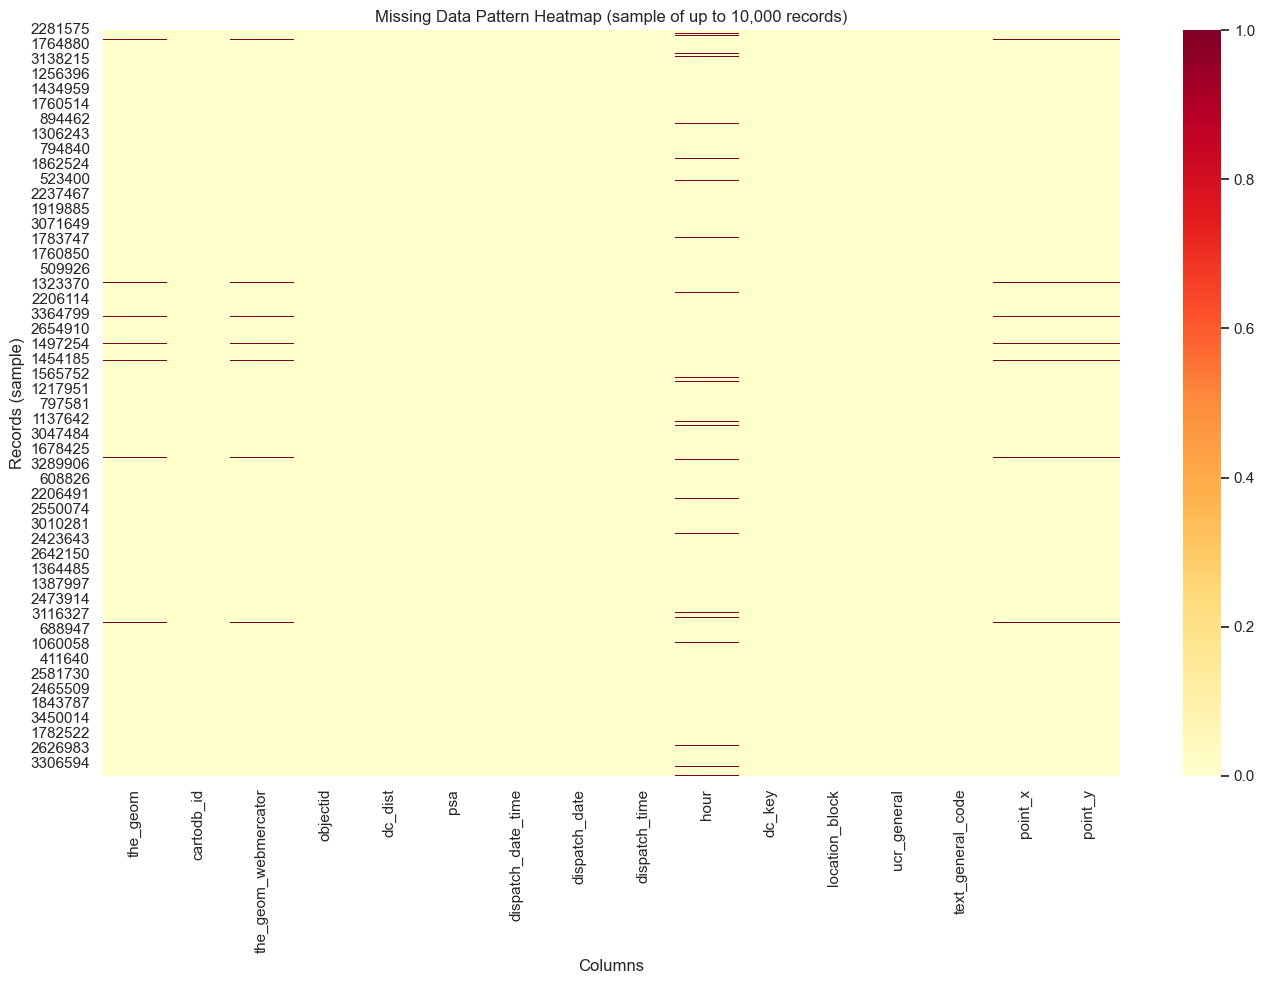

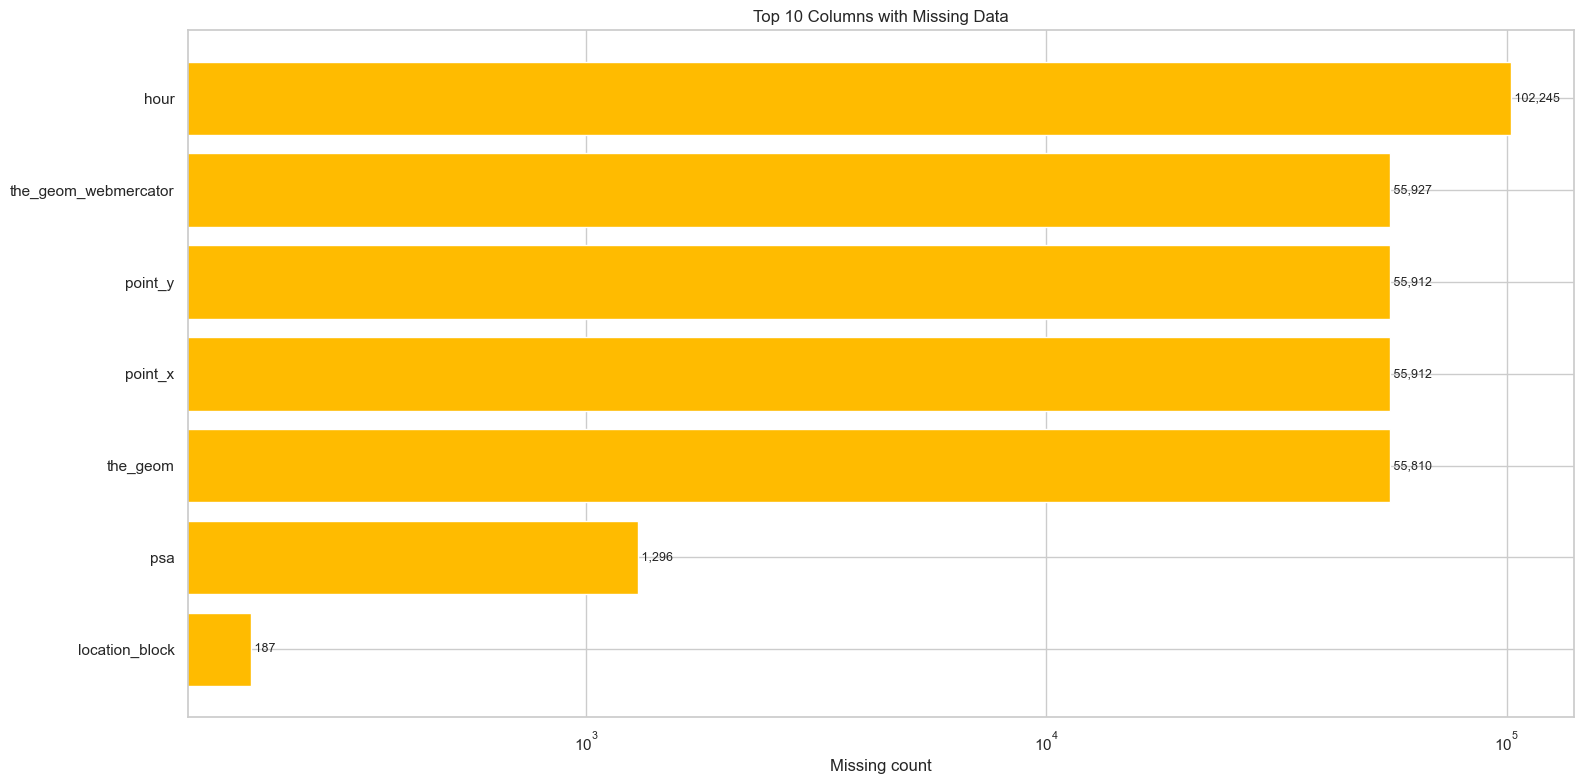

In [8]:
# Prepare missing summary (compute if not present)
try:
    missing_summary
except NameError:
    missing_summary = get_missing_summary(df)

# Missing data visualization
# Create a heatmap of missingness (sample if dataset is large)
fig, ax = plt.subplots(figsize=FIGURE_SIZES["large"])
sample_df = df.sample(n=min(10000, len(df)), random_state=42)
missing_sample = sample_df.isnull().astype(int)

sns.heatmap(missing_sample, cbar=True, cmap="YlOrRd", ax=ax)
ax.set_title("Missing Data Pattern Heatmap (sample of up to 10,000 records)")
ax.set_xlabel("Columns")
ax.set_ylabel("Records (sample)")
plt.tight_layout()
plt.show()

# Missing data bar chart for top columns
fig, ax = plt.subplots(figsize=FIGURE_SIZES["wide"])
if not missing_summary.empty:
    missing_plot = missing_summary.head(10).sort_values("missing_count")
    bars = ax.barh(missing_plot["column"], missing_plot["missing_count"], color=COLORS["warning"])
    ax.set_xlabel("Missing count")
    ax.set_title("Top 10 Columns with Missing Data")
    ax.set_xscale("log")
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f" {format_number(int(width))}", va="center", fontsize=9)
plt.tight_layout()
plt.show()

## Section 5 — Coordinate Coverage Analysis

This section analyzes geographic coverage and validity of coordinate data and tests coverage differences by crime type and district.

### Coordinate Coverage — Summary

- Total records: **3,496,353**
- Valid coordinates: **3,440,053** (98.39%)
- Invalid coordinates: **56,300** (1.61%)
  - Missing: **55,912** (1.60%)
  - Invalid longitude: **388** (0.01%)

These figures indicate high spatial coverage; see visualizations and per-group breakdowns below.

#### Coverage by Group — Highlights

Coordinate coverage varies slightly by crime type and district. Statistical tests:
- Coverage by crime type: chi-square = **8,692.35**, p < 0.001, Cramer's V = **0.050** (negligible)
- Coverage by district: chi-square = **207,930.76**, p < 0.001, Cramer's V = **0.244** (weak)

Refer to the plots below for the highest and lowest coverage categories.

Coordinate coverage visualizations generated.

## Section 6: Duplicate Detection

This section identifies duplicate records in the dataset through multiple approaches: exact duplicates, key column duplicates, and geographic proximity analysis.

### Duplicate Detection — Summary

- Exact duplicates: **0** (0.00%)
- Duplicated by `objectid`: **0** (0.00%)
- Duplicated by `dc_key`: **230** (0.01%)

Geographic duplicates (same location):
- Unique locations with multiple incidents: **79,988**
- Incidents at multi-incident locations: **3,344,377** (97.21%)

Multiple reports (same date, district, crime type):
- Combinations with multiple incidents: **764,207**
- Incidents in multi-report combinations: **2,831,870** (80.99%)

Overall, duplicate rates are low; some locations naturally contain multiple incidents.

## Section 7: Outlier Detection

This section identifies outliers in coordinate, numerical, and temporal data using various statistical methods to detect potentially erroneous records.

### Outlier Detection — Summary

- Coordinate outliers: **56,300** (1.61%)
  - Missing coordinates: **55,912** (1.60%)
  - Invalid longitude: **388** (0.01%)

- Numerical outliers: IQR-based checks performed on 12 numeric fields (details below).

- Temporal outliers: date range **2006-01-01 to 2026-01-20**; no future or pre-2006 dates detected.

Outlier checks completed; refer to the plots and detailed tables for flagged records.

## Section 8: Temporal Gaps Analysis

This section analyzes temporal gaps in the data, identifying dates with no incidents, longest gaps without data, and creates a time series visualization of daily incident counts.

### Temporal Gaps Analysis — Summary

- Date coverage: **2006-01-01 to 2026-01-20**
- Total days: **7,325** (days with incidents: **7,324**; days without incidents: **1**)
- Longest data gap: **1 day** (2025-03-10)

Daily incident count statistics:
- Mean: **477.4** incidents/day
- Median: **477** incidents/day
- Min: **61** incidents/day
- Max: **855** incidents/day
- Std Dev: **98** incidents/day

Time series and distribution plots are available below.

## Section 9 — Quality Score Calculation

Component scores:
- Completeness: **96.39%** (missing cells: 3,665,097 / 101,394,237)
- Accuracy: **98.39%**
- Consistency: **100.00%** (duplicates: 0 / 3,496,353)
- Validity: **98.39%**

**Overall quality score:** **97.83 / 100** (Grade: **A — Excellent**)

Refer to the radar chart and component breakdown for visual context.

## Section 10: Comprehensive Analysis Report

All analysis results, findings, and recommendations are displayed below as an integrated report within this notebook.

Generating integrated report...  
The consolidated report below highlights key findings, component scores, and recommended next steps for data stewardship and analysis readiness.

## Section 11: Executive Summary

## Executive Summary

**Overall quality:** **97.83 / 100** (Grade: **A — Excellent**)

**Component scores:**
- Completeness: **96.39%** (40% weight)
- Accuracy: **98.39%** (30% weight)
- Consistency: **100.0%** (15% weight)
- Validity: **98.39%** (15% weight)

**Key findings:**
- Coordinate coverage is high: **98.39%** valid (1.61% invalid).  
- Duplicate records are negligible: **0** exact duplicates; **230** duplicates by `dc_key`.

**Recommendations:**
- Proceed with spatial analyses after excluding or flagging records with missing/invalid coordinates.  
- Investigate `dc_key` duplicates to determine if deduplication or aggregation is appropriate for specific analyses.  
- Document and monitor data collection changes that could affect missingness or coverage over time.

**Limitations:** All statistical tests used a 99% confidence level for conservative inference; missingness tests were performed with chi-square tests.